# Face Generation

Este projeto tem como objetivo criar **redes adversárias geradoras (generative adversarial networks)** para a criação de imagens de dígitos e faces com base em um dataset conhecido.

### Dataset

Vamos utilizar neste processo dois datasets:
- [MNIST](http://yann.lecun.com/exdb/mnist/)
- [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

Como o conjunto de dados **CelebA** é complexo e computacionalmente dispendioso. Vamos usar o **MNIST** para testar nossa **rede neural** antes de moer nossas **GANs** para criar faces.

In [1]:
data_dir = './data'

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


### MNIST

O conjunto de dados [MNIST](http://yann.lecun.com/exdb/mnist/) contém imagens de dígitos manuscritos.

**28 x 28**

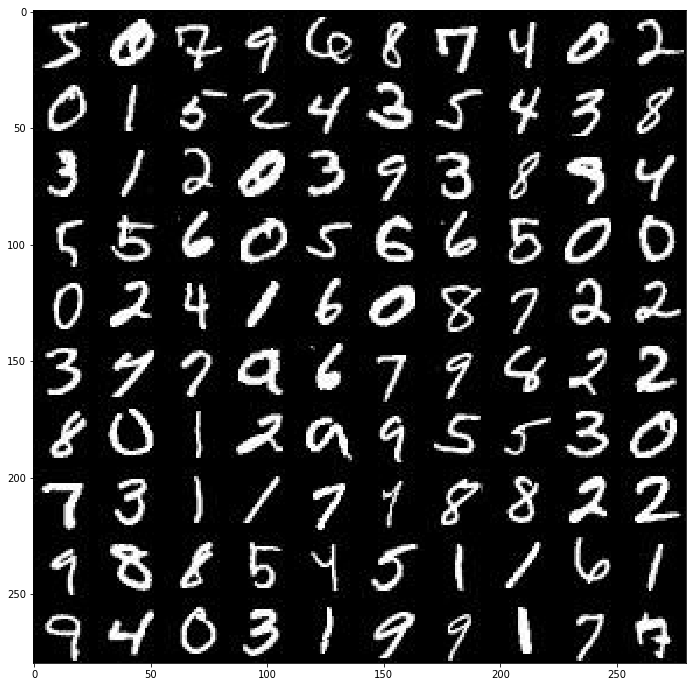

In [2]:
show_n_images = 120

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import time

pyplot.rcParams["figure.figsize"] = (12,12)

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

# CelebA

O conjunto de dados [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) contém mais de **200.000** imagens de celebridades com anotações. Como você vai gerar faces, não vai precisar das anotações.

**178 x 218**

Wall time: 1.08 s


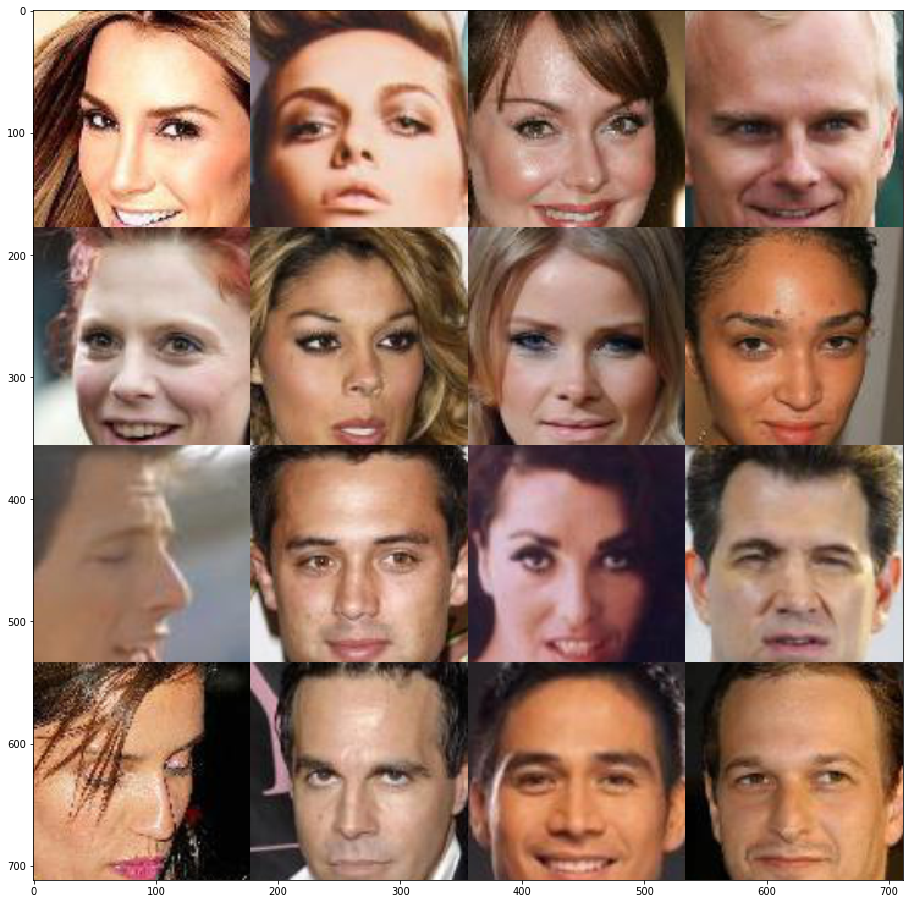

In [4]:
%%time

show_n_images = 16

pyplot.rcParams["figure.figsize"] = (16,16)

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 178, 178, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data

Como o foco principal do projeto é construir as GANs, vamos pré-processar os dados. Os valores do conjunto de dados MNIST e CelebA estarão com 28x28 piexeis. As imagens da CelebA serão cortadas para remover partes da imagem que não incluem um rosto e redimensionadas para 28x28.


## Build the Neural Network

Os passos para a construção desta NNA são:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU

Vamos verificar a versão do TensorFlow e se temos acesso a GPU...

In [5]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    realInputImages =  tf.placeholder( tf.float32, 
                                       (None, image_width, image_height, image_channels), 
                                       'real_inputs')
    
    input_z = tf.placeholder(tf.float32, (None, z_dim), 'input_z' )
    
    learningRates = tf.placeholder(tf.float32, name='learning_rate', shape=())

    return realInputImages, input_z, learningRates

tests.test_model_inputs(model_inputs)

Tests Passed


## Discriminator

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        lrelu1 = tf.maximum(alpha * x1, x1)
                
        x2 = tf.layers.conv2d(lrelu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
                
        x3 = tf.layers.conv2d(lrelu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
               
        x4 = tf.layers.conv2d( x3, 512, 5, strides=1, padding='same' )
        bn4 = tf.layers.batch_normalization(x4, training=True)
        lrelu4 = tf.maximum(alpha * bn4, bn4)

        flat = tf.reshape(lrelu3, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


## Generator

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.1
    reuse = not is_train # if training do not reuse vars
    
    with tf.variable_scope('generator', reuse=reuse):
        
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 3, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)

        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=2, padding='same')
        
        out = tf.tanh(logits)

        return out

tests.test_generator(generator, tf)

Tests Passed


## Loss

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

tests.test_model_loss(model_loss)

Tests Passed


## Optimization

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

## Train

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0;
    show = 100
    
    input_real, input_z, learningRates = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)    
    d_loss, g_loss = model_loss( input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt( d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1;                
                batch_images = batch_images * 2                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={ input_real: batch_images, input_z: batch_z })
                _ = sess.run(g_opt, feed_dict={ input_z: batch_z , input_real : batch_images})
                
                if steps % show == 0:
                    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    show_generator_output( sess, 36, input_z, data_shape[3], data_image_mode)


### MNIST

Chegou a hora de testar nossas **GANs** no MNIST. Depois de 2 épocas, as GANs devem poder gerar imagens que se pareçam com dígitos manuscritos. 

Vale notar que a perda do **gerador** deve ser menor que a perda do **discriminador** ou pelo menos próxima de 0.

Epoch 1/2... Discriminator Loss: 0.8773... Generator Loss: 2.9685


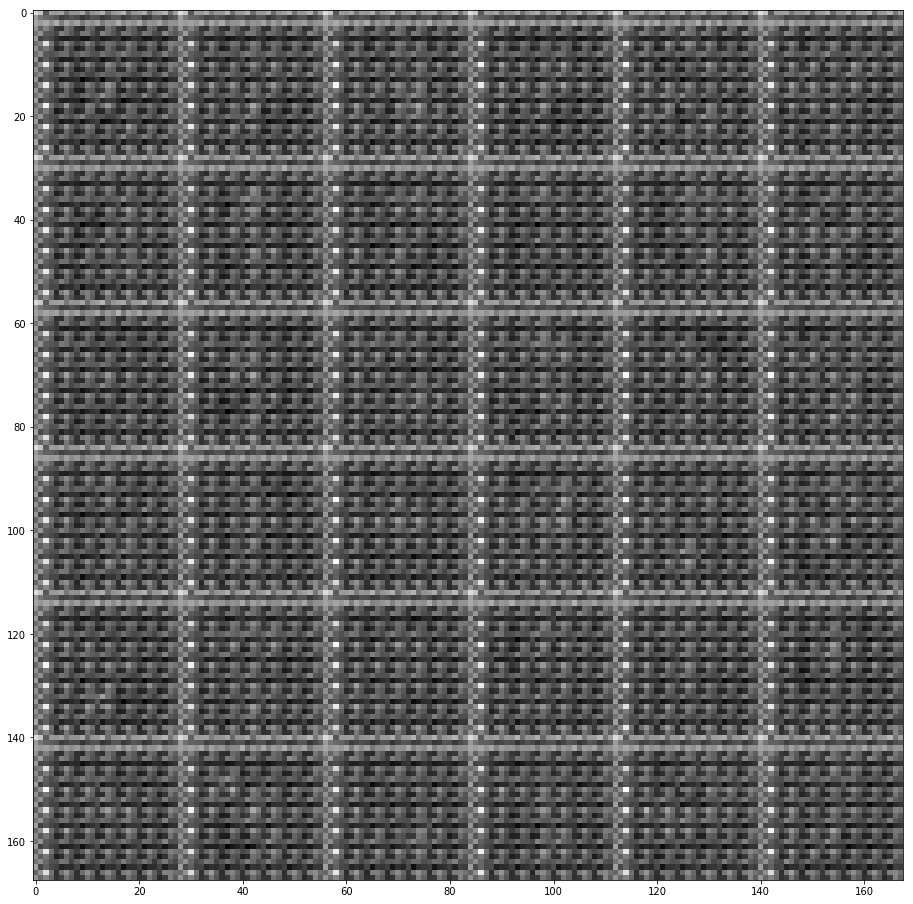

Epoch 1/2... Discriminator Loss: 1.2578... Generator Loss: 0.5032


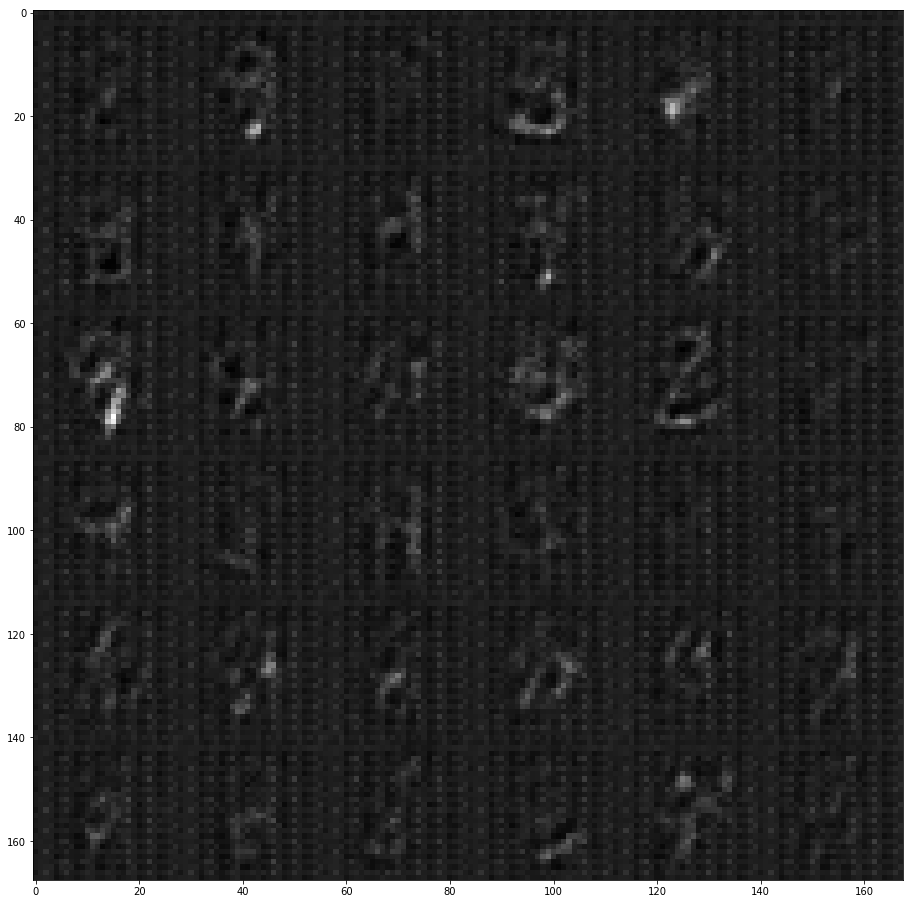

Epoch 1/2... Discriminator Loss: 1.0046... Generator Loss: 0.6429


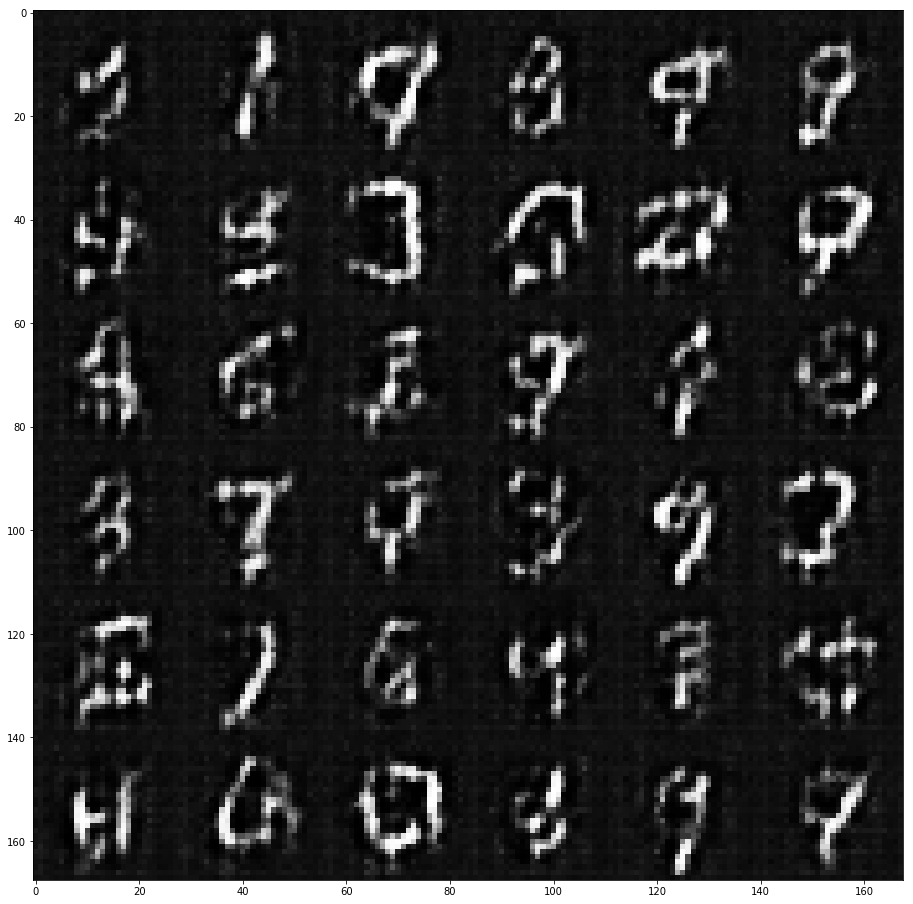

Epoch 1/2... Discriminator Loss: 1.0861... Generator Loss: 1.6936


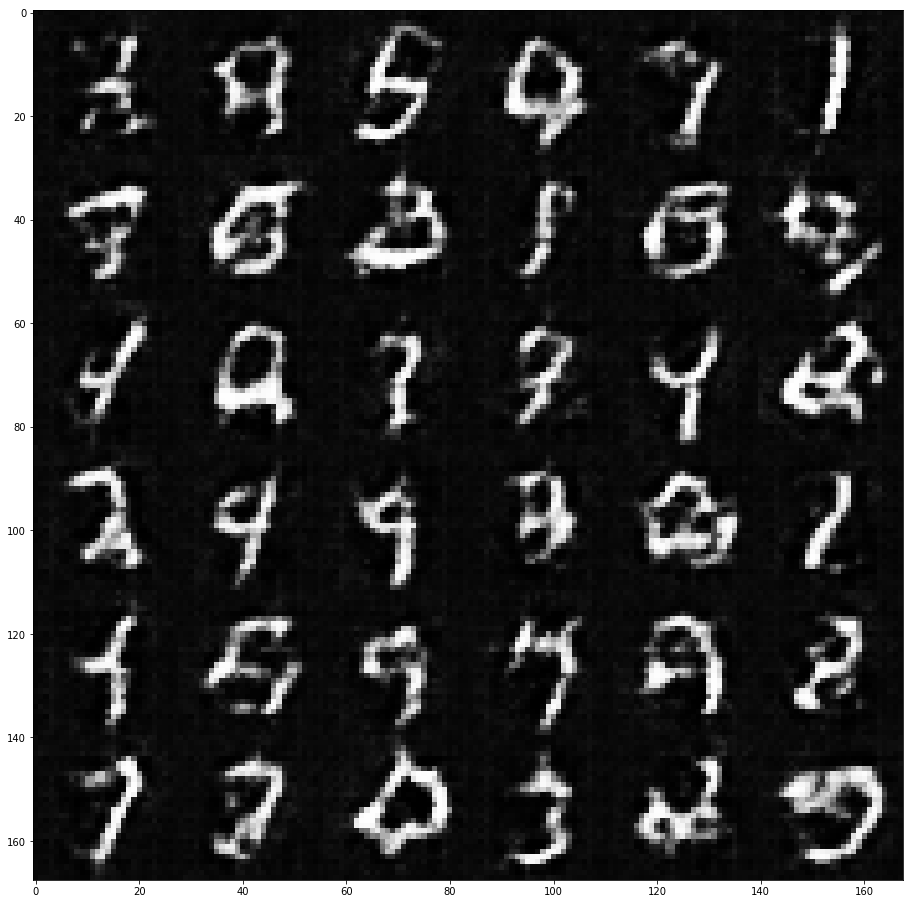

Epoch 2/2... Discriminator Loss: 1.2885... Generator Loss: 0.4347


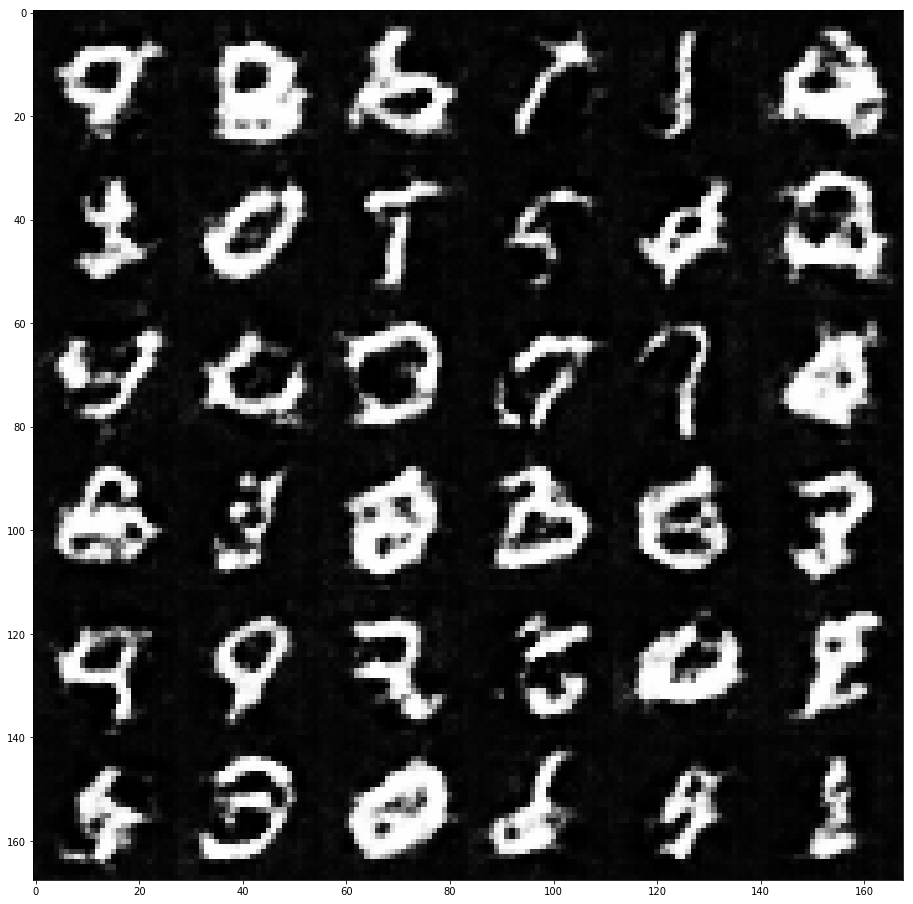

Epoch 2/2... Discriminator Loss: 3.4235... Generator Loss: 0.0539


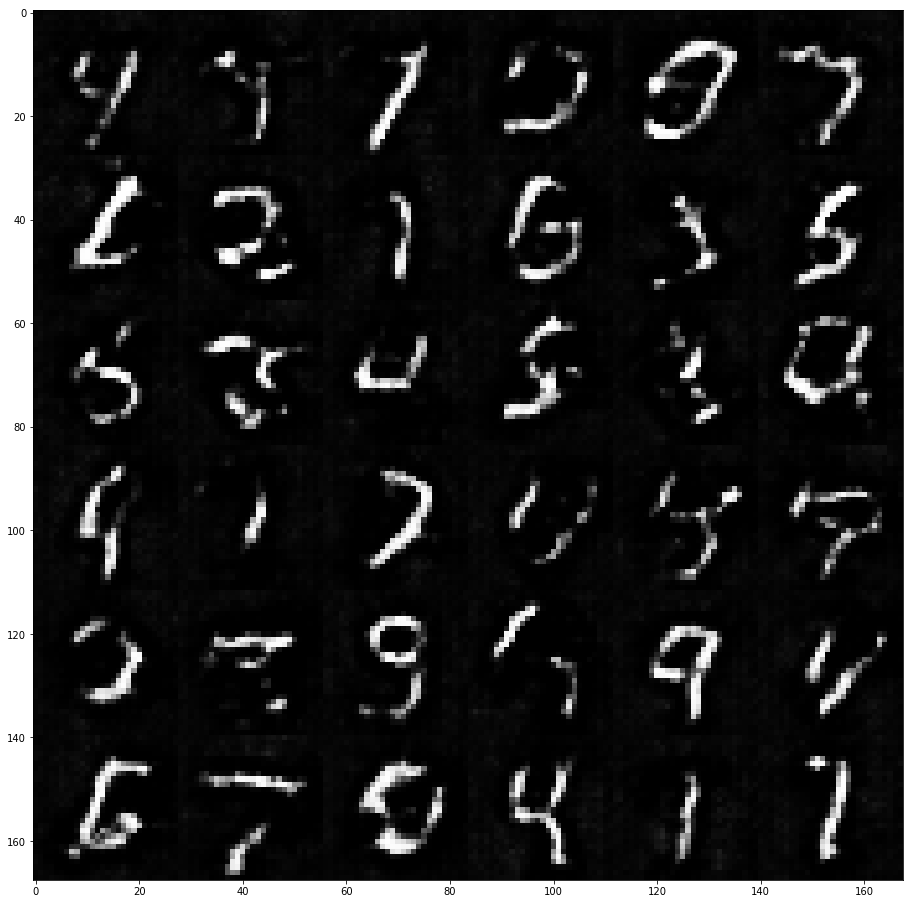

Epoch 2/2... Discriminator Loss: 1.7183... Generator Loss: 0.2702


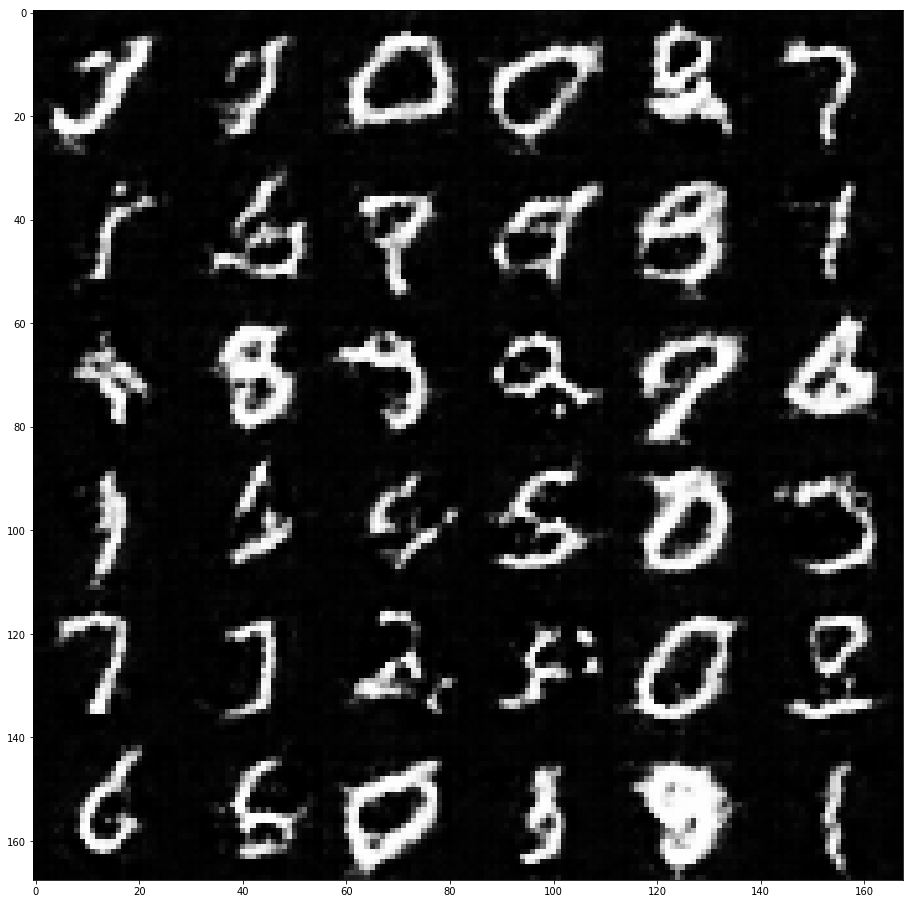

Epoch 2/2... Discriminator Loss: 1.0083... Generator Loss: 0.7240


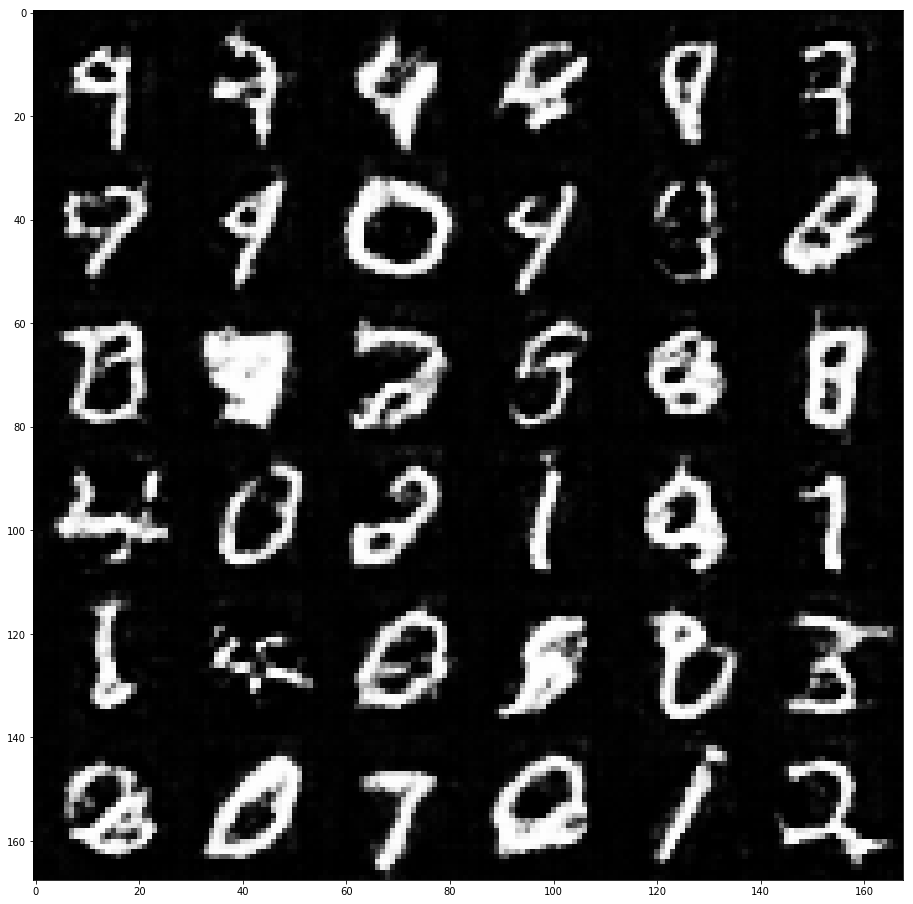

Epoch 2/2... Discriminator Loss: 1.3672... Generator Loss: 1.1645


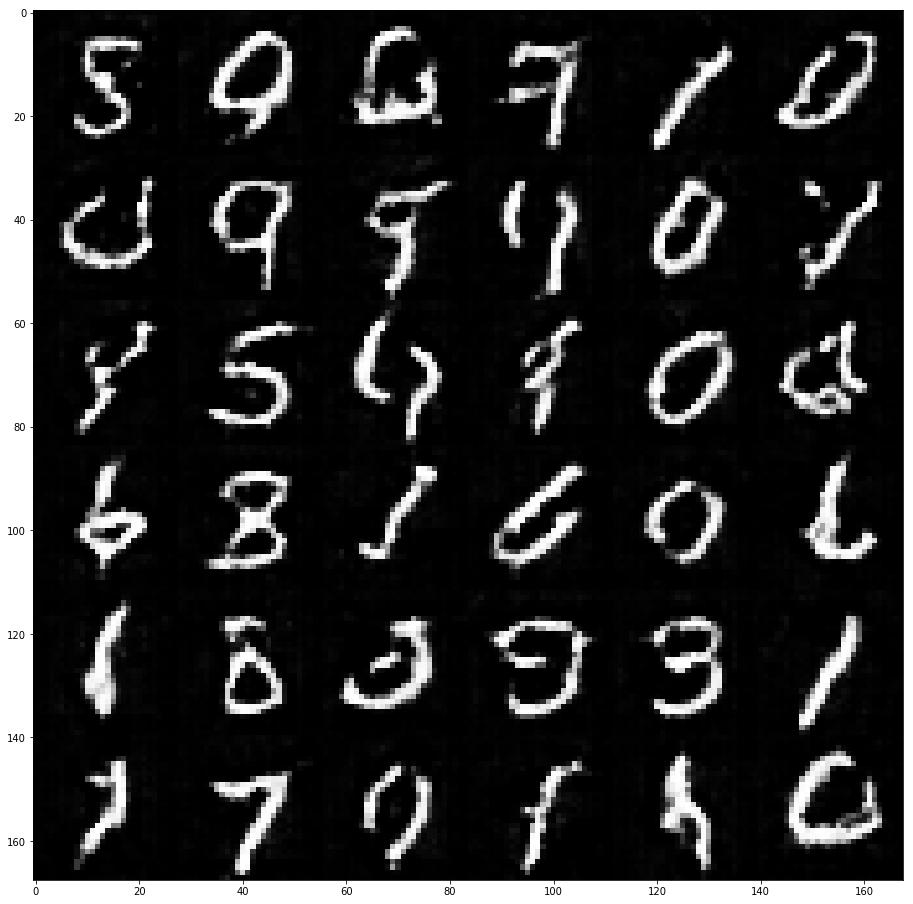

Wall time: 6min 35s


In [14]:
%%time

batch_size = 128
z_dim = 128
learning_rate = 0.0004
beta1 = 0.5

epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

## CelebA

Agora vamos criar pessoas... Demora cerca de 25 minutos em uma GPU padrão... processando no **Azure** foram 16 minutos. 

Epoch 1/1... Discriminator Loss: 1.9915... Generator Loss: 4.1040


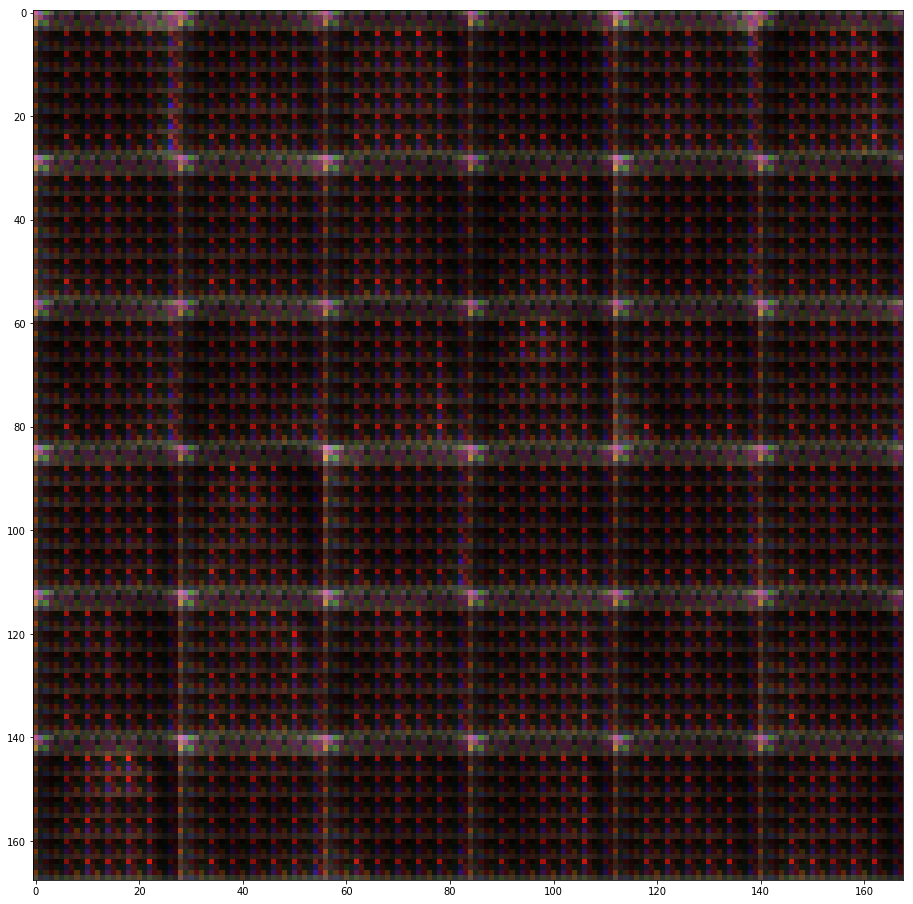

Epoch 1/1... Discriminator Loss: 0.7060... Generator Loss: 1.7421


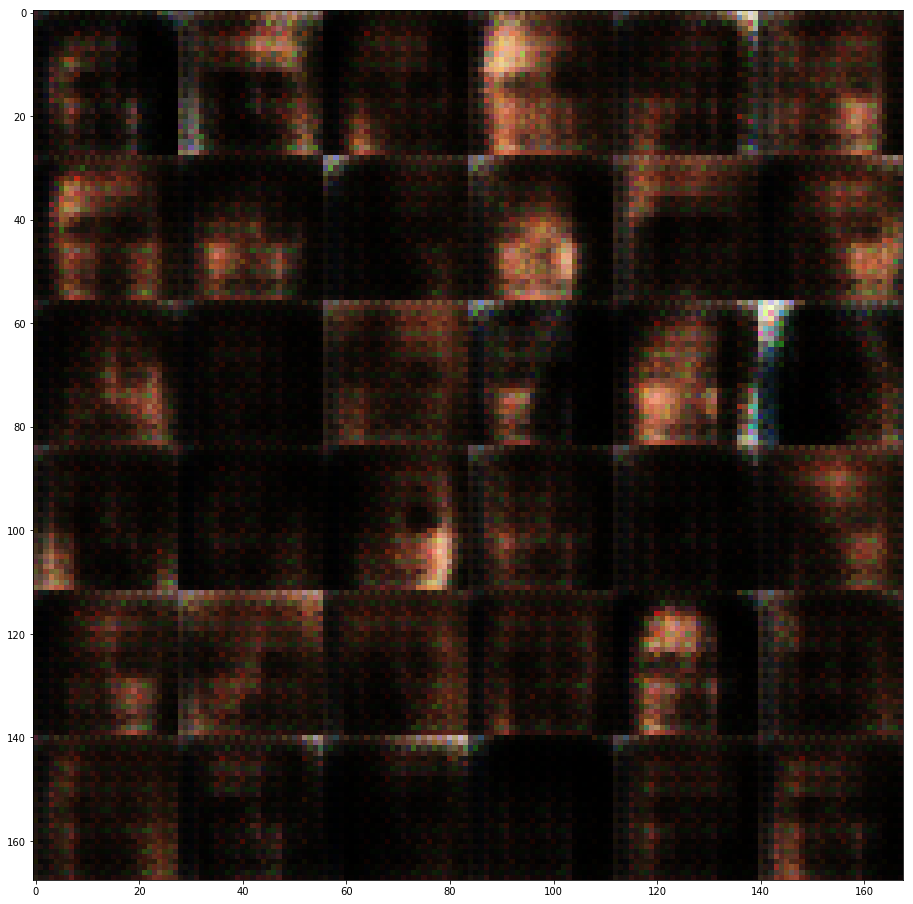

Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.7588


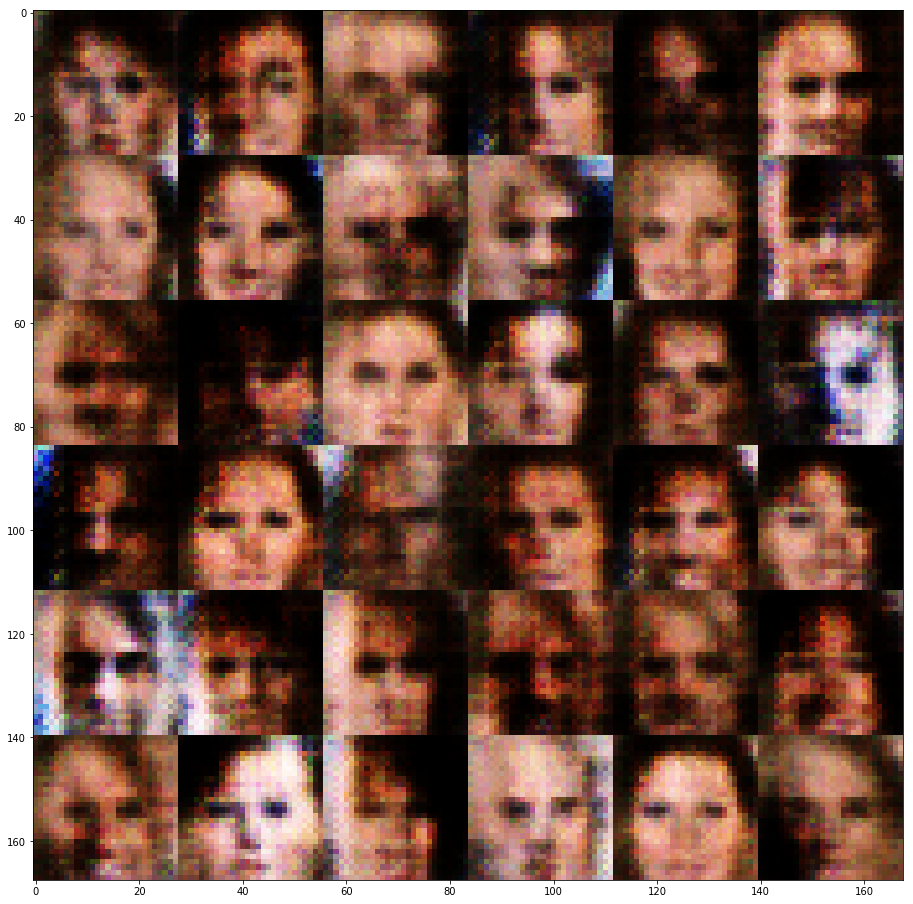

Epoch 1/1... Discriminator Loss: 2.8516... Generator Loss: 0.0860


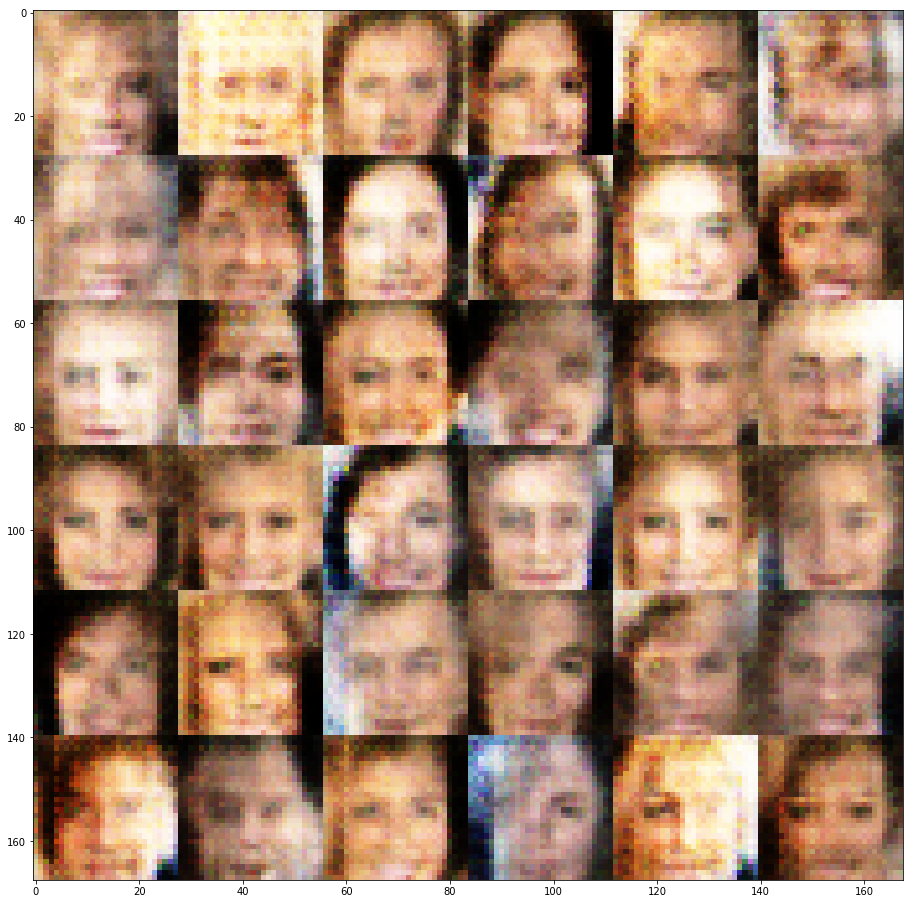

Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 1.6300


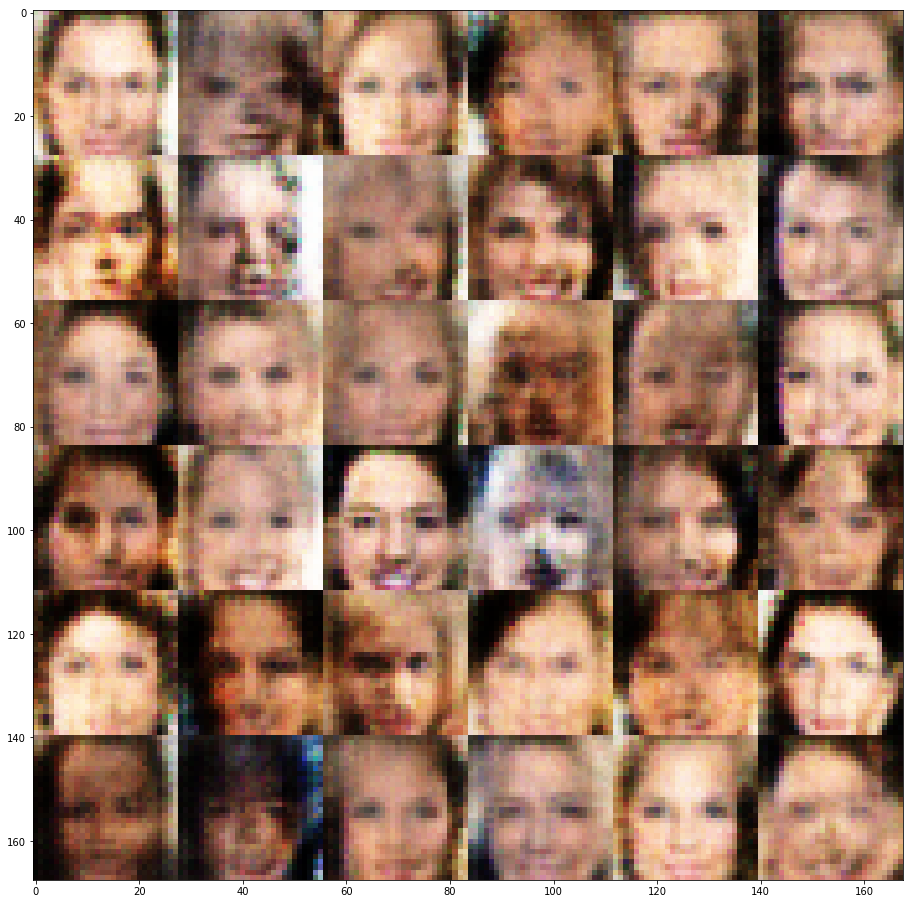

Epoch 1/1... Discriminator Loss: 2.0580... Generator Loss: 3.0117


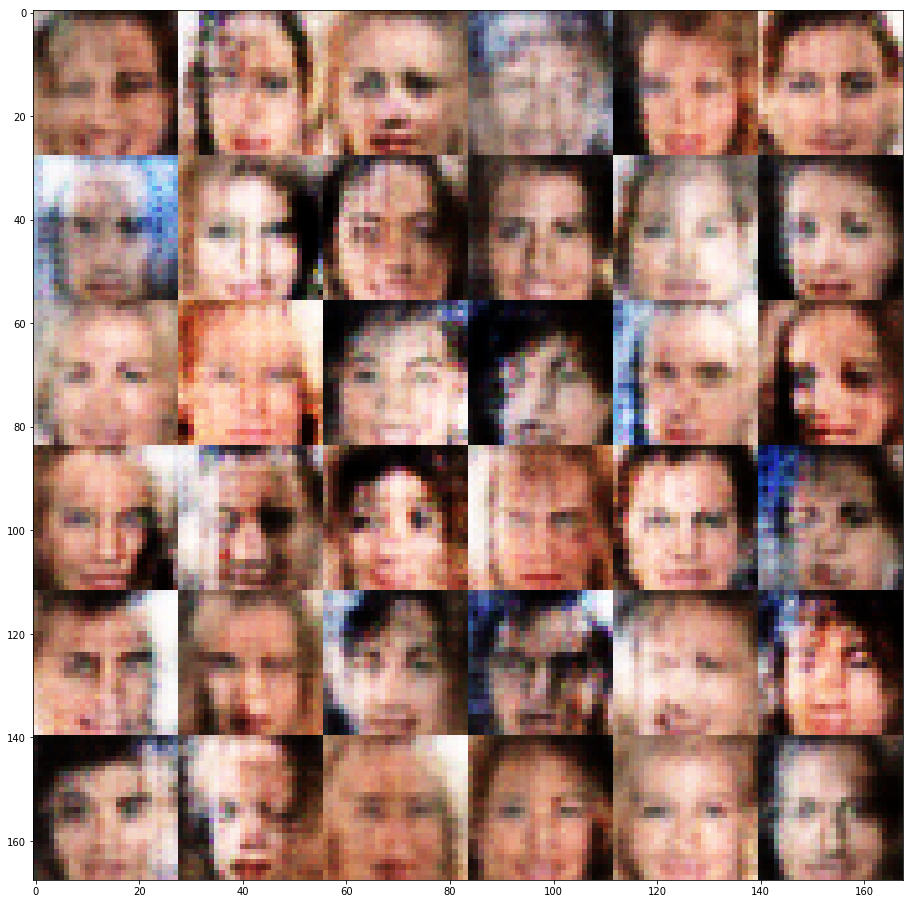

Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 1.3424


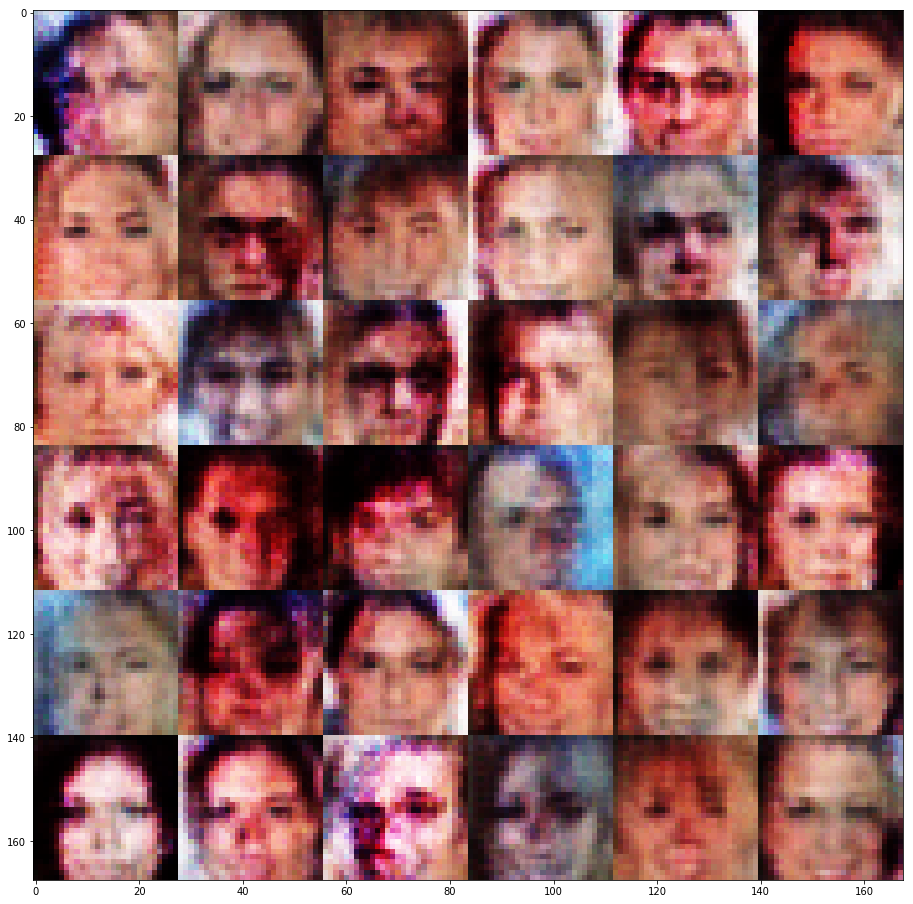

Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.5782


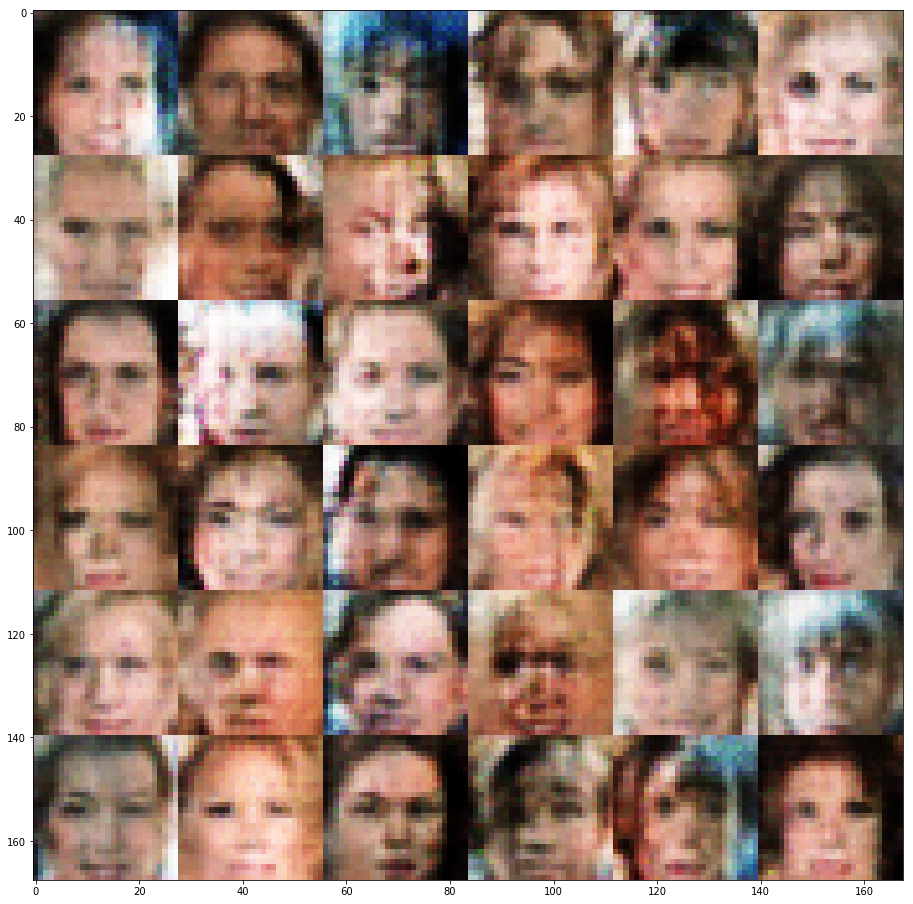

Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.7216


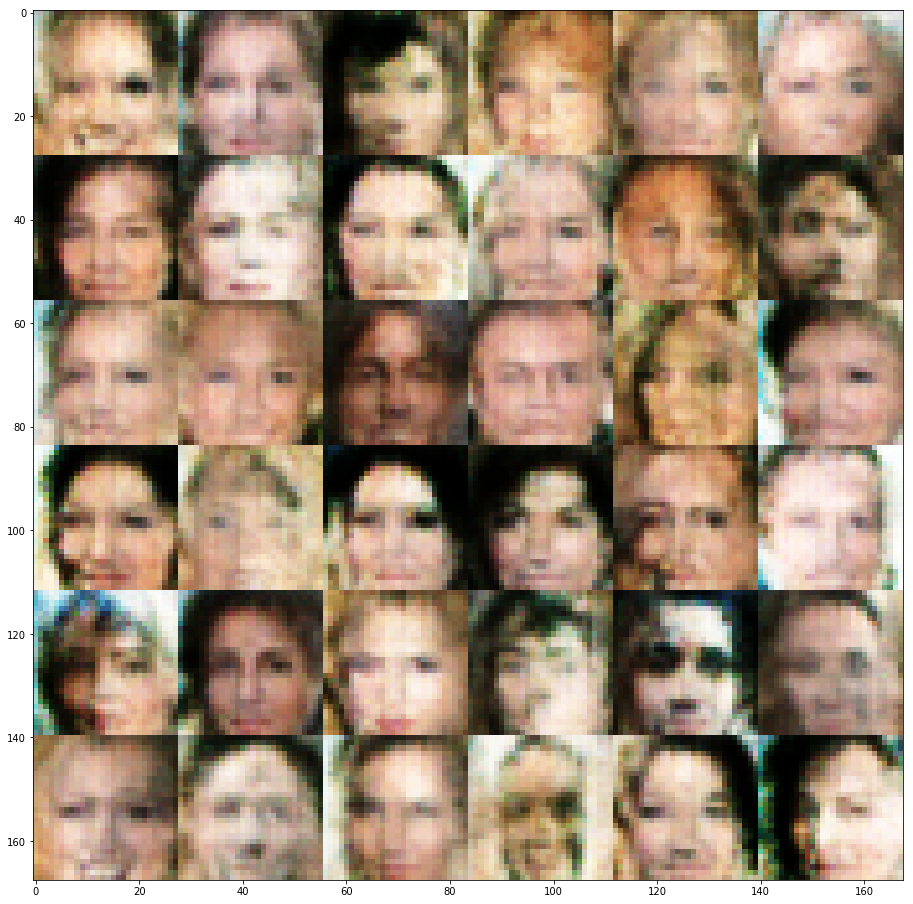

Epoch 1/1... Discriminator Loss: 1.8056... Generator Loss: 0.2761


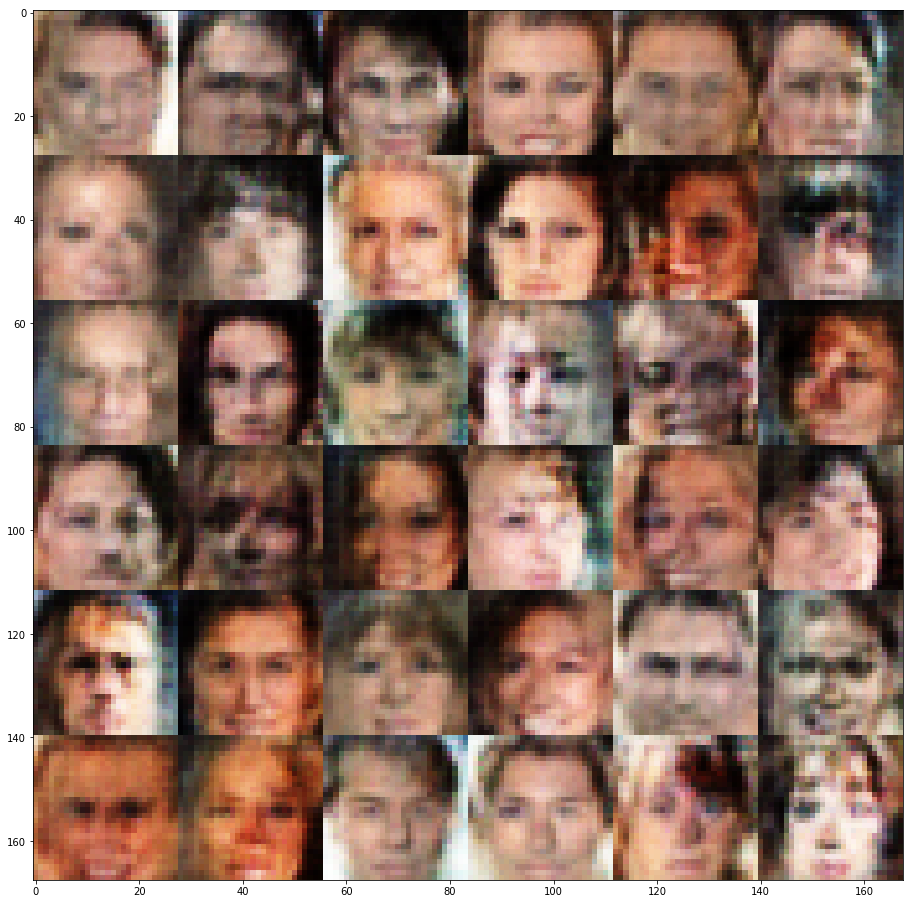

Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.6573


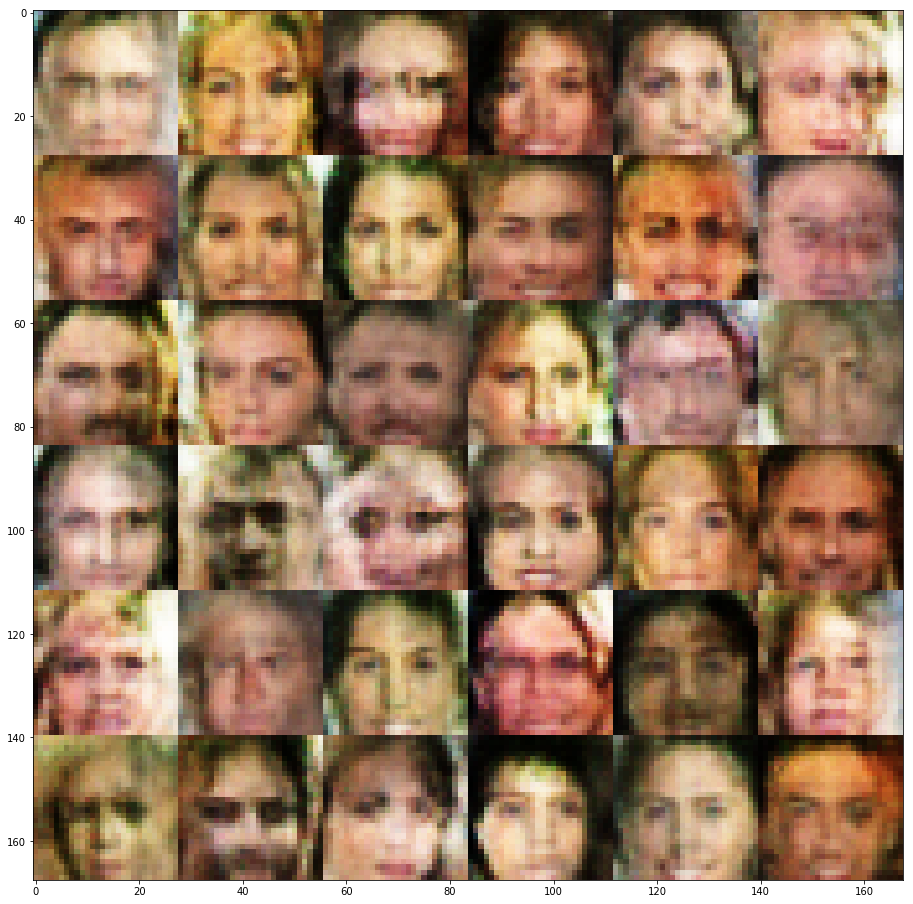

Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.7880


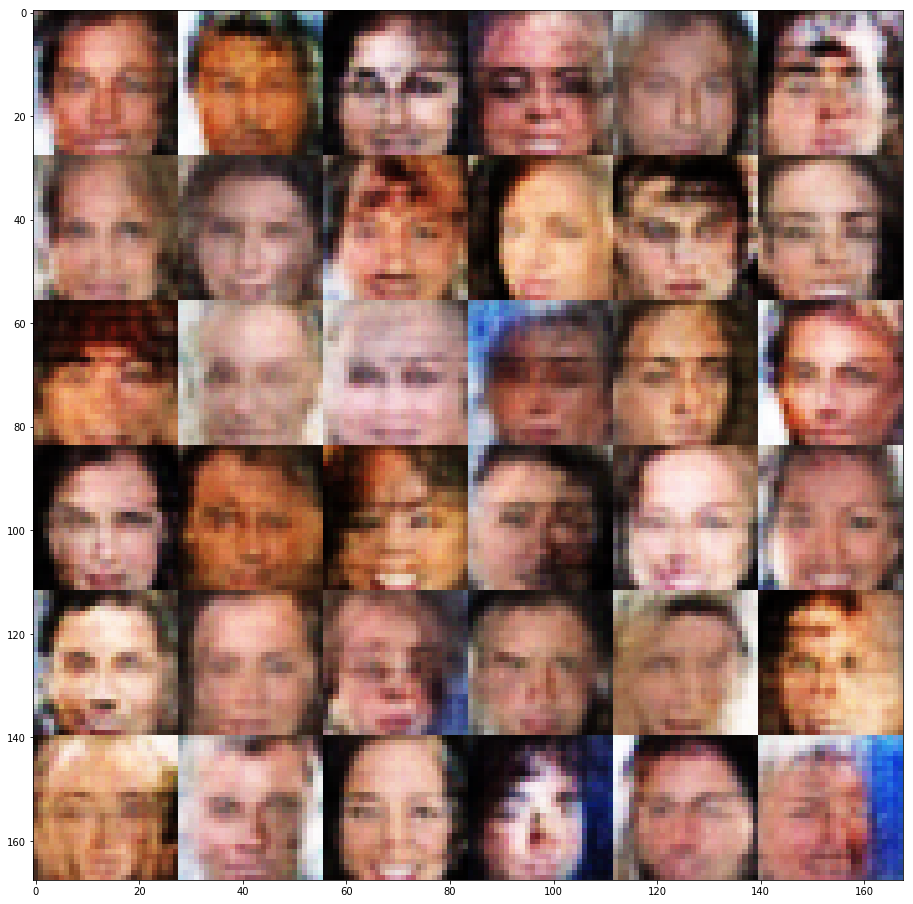

Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 1.1921


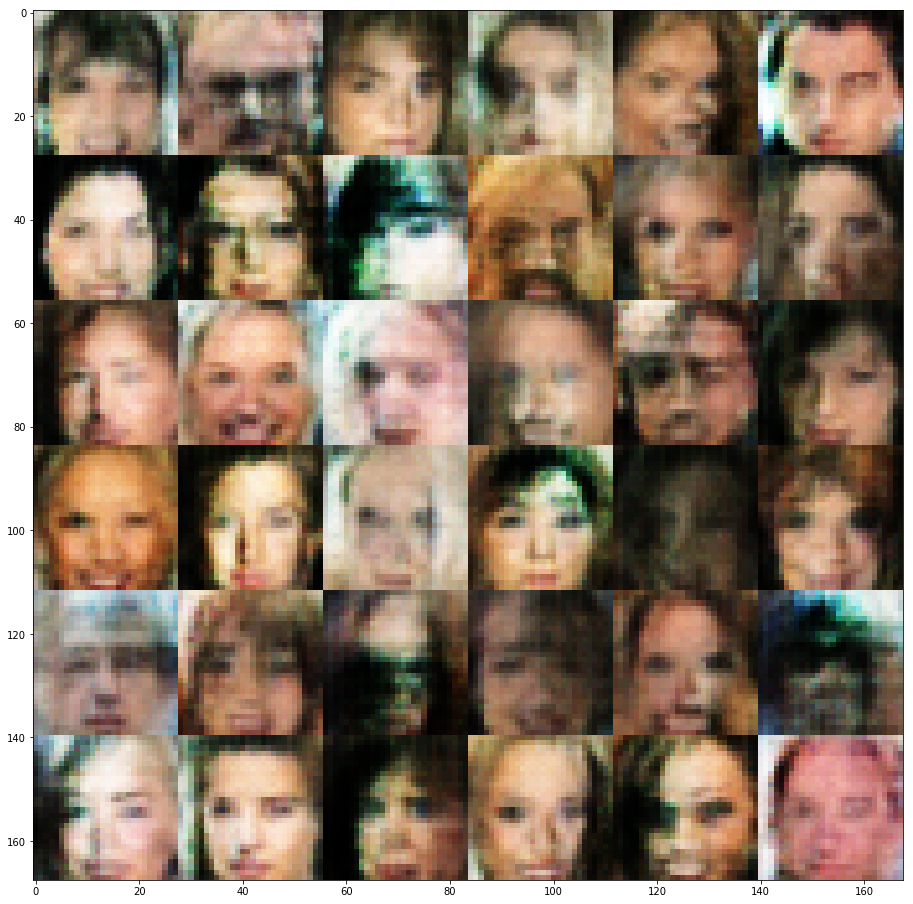

Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 0.6900


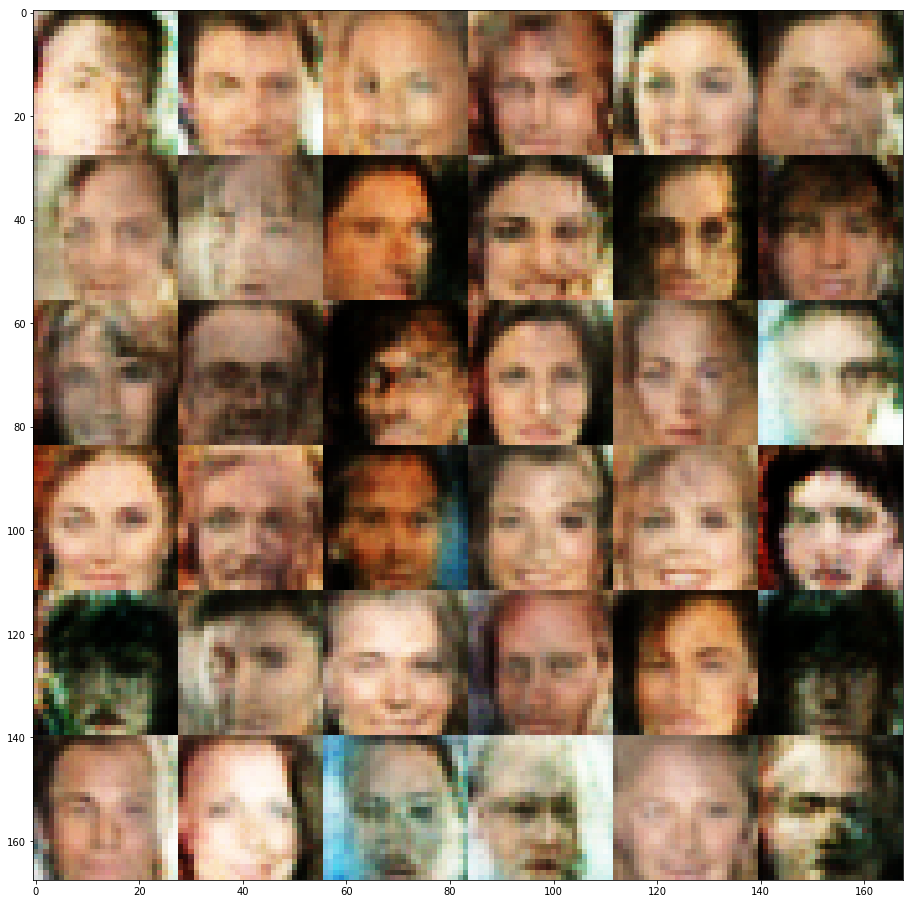

Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.8324


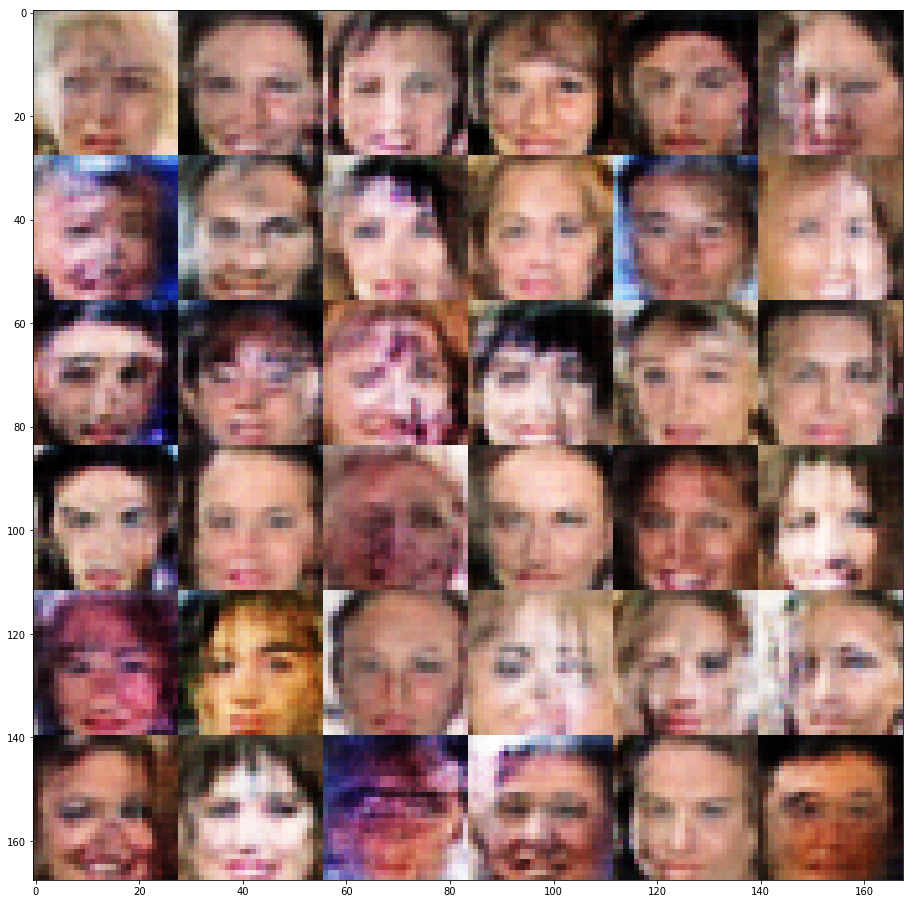

Wall time: 16min 22s


In [15]:
%%time

batch_size = 128
z_dim = 128
learning_rate = 0.0004
beta1 = 0.5

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)